# Tritium desorption in fusion reactor walls

In this example, we look at the ability of `twinLab` to model the [desorption](https://en.wikipedia.org/wiki/Desorption) (the physical process where a previously adsorbed substance is released from a surface) of tritium (a radioactive isotope of hydrogen) in the wall of a nuclear fusion reactor. Fusion generates almost no radioactive waste, and the little waste that it does produce has a short half-life. However, the interior of the reactor wall is bombarded by a high-neutron flux during fusion, far higher than any naturally-occurring radioactive process, and therefore the properties of materials under high neutron bombardment are unknown. Computer simulations are required to understand the material properties in such extreme circumstances, but simulations are expensive in terms of computational power, and cannot be run at every point in parameter space under consideration. `twinLab` can be used to train simulation surrogate models using data from a sparse array of simulations. This allows for meaningful interpolation and extrapolation to unexplored regions of parameter space, together with a calibrated uncertainty estimate on the accuracy of the simulation surrogate.

First, import the required libraries

In [1]:
# Standard imports
from pprint import pprint

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Project imports
import twinlab as tl


      == Client Initialisation ==
      Local Server  : http://localhost:3000
      Cloud Server  : https://z2seun1aee.execute-api.eu-west-2.amazonaws.com/Prod
      Group Name    : digilab
      User Name     : mead
      


Now, define some parameters. We need to provide `twinLab` with locations of data files (in `.csv` format) and directories, together with a chosen surrogate campaign name (here `ukaea`) and a list of the input parameters that we are going to use as inputs to our model. Here these 5 parameters are $E_1$, $E_2$, $E_3$, $n_1$, and $n_2$ and quantify properties of the material that can trap tritium nuclei. The $E_i$ parameters are energies while the $n_i$ parameters are particle number densities. $E_1$ and $n_1$ pertain to the same trap, as do $E_2$ and $n_2$, but in the model parameterized by $E_3$ the value of $n_3$ is calculated internally, and evolves with time, and therefore this is not an input parameter for our training regime.

In [2]:
# Files and file paths
campaign_dir = "resources/campaigns/ukaea/"
datasets_dir = "resources/datasets/"
dataset = "ukaea.csv"
file_grid = campaign_dir + "grid.csv"
file_train = datasets_dir + dataset
# file_eval = campaign_dir + "eval.csv"
# file_eval = campaign_dir + "post.csv"
file_eval = campaign_dir + "test.csv"

# Campaign parameters
campaign = "ukaea"
inputs = ["E1", "E2", "E3", "n1", "n2"]

Load the necessary data from `.csv` files for training and plotting

In [3]:
df_train = pd.read_csv(file_train)
df_eval = pd.read_csv(file_eval)
df_grid = pd.read_csv(file_grid, header=None)

Next, we create the parameter dictionary that we need to give to run twinLab.  At a minimum the user must provide the `filename` of the dataset on which we want to train our model (`.csv` format), together with the columns that we will take to be the `inputs` and `outputs` of our model, once that is trained. By default, `twinLab` will use all of the data for training. This latter choice can be overridden by adding e.g., `train_test_split=1000` so that only the first 1000 entries in `filename` are used for training, and the remaining examples are then used for internal model evaluation.

In this case we are training a functional model, which means that we want to return a *function* at every point in parameter space ($E_1$, $E_2$, $E_3$, $n_1$, $n_2$). In this case, our function describes the tritium desorption rate, $D$, of the material of the reactor wall as a function of temperature (rate of emitted nuclei per reactor wall area). The training of the surrogate is agnostic to the values of reactor temperature, $T$, so we must provide this by hand (`df_grid` above, from `file_grid`). The output of our model will therefore be the function $D(T; E_1, E_2, E_3, n_1, n_2)$.

The `twinLab` model achieves this by predicting the value of $D$ at $\sim 500$ points in $T$ in a regularly-spaced grid between $300\mathrm{K}$ and $800\mathrm{K}$. The correlations between points adjacent in $T$ are incorporated naturally by the model, and `twinLab` provides a model uncertainty. Here we call the outputs `y`, rather than `D`, as per the typical data-science convention.

In [4]:
# Column headings for outputs
y_outputs = [f"y{i}" for i in range(len(df_grid))]

# Parameters
params = {
    "filename": dataset,
    "inputs": inputs,
    "outputs": y_outputs,
    "decompose_outputs": True,
    "train_test_split": 1024,
}

Now the dataset can be uploaded to the cloud

In [5]:
tl.upload_dataset(file_train, verbose=True)

Response: Presigned URL generated successfully

Uploading resources/datasets/ukaea.csv
File resources/datasets/ukaea.csv uploaded successfully.

Response: Dataset ukaea.csv processed successfully



List all of the datasets under our username to check that the upload worked

In [6]:
datasets = tl.list_datasets(verbose=True)
pprint(datasets)

Response: Found 4 datasets

['cosmo_random.csv',
 'cosmology_latin_small.csv',
 'cosmology_random_small.csv',
 'ukaea.csv']


Print some useful properties of the dataset

In [7]:
query = tl.query_dataset(params["filename"], verbose=True)
pprint(query)

Response: Dataset summary for ukaea.csv

Summary:
                 E1           E2           E3           n1           n2  \
count  4096.000000  4096.000000  4096.000000  4096.000000  4096.000000   
mean      0.850000     1.100000     1.425000     0.002750     0.000550   
std       0.086613     0.115484     0.187662     0.001299     0.000260   
min       0.700046     0.900088     1.100129     0.000500     0.000100   
25%       0.775034     1.000053     1.262581     0.001626     0.000325   
50%       0.849975     1.099983     1.425016     0.002750     0.000550   
75%       0.924985     1.199979     1.587442     0.003875     0.000775   
max       0.999995     1.299965     1.749911     0.004999     0.001000   

                 y0            y1            y2            y3            y4  \
count  4.096000e+03  4.096000e+03  4.096000e+03  4.096000e+03  4.096000e+03   
mean   6.090767e+16  6.581552e+16  7.111414e+16  7.682121e+16  8.294281e+16   
std    6.766648e+16  7.287118e+16  7.845608e+

/Users/mead/Library/Caches/pypoetry/virtualenvs/nuclear-energy-Of9wSoh_-py3.9/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)


Train the surrogate model, this step takes around 6 minutes.

In [8]:
tl.train_campaign(params, campaign, verbose=True)

Response: Training ukaea complete



List the campaigns again to ensure that training has been completed

In [9]:
campaigns = tl.list_campaigns(verbose=True)
pprint(campaigns)

Response: Found 1 campaign

['ukaea']


Query the campaign to check how training has proceeded

In [10]:
_ = tl.query_campaign(campaign, verbose=True)

Response: Query of ukaea campaign complete

Metadata:
{'inputs': ['E1', 'E2', 'E3', 'n1', 'n2'],
 'outputs': ['y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10',
             'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19',
             'y20', 'y21', 'y22', 'y23', 'y24', 'y25', 'y26', 'y27', 'y28',
             'y29', 'y30', 'y31', 'y32', 'y33', 'y34', 'y35', 'y36', 'y37',
             'y38', 'y39', 'y40', 'y41', 'y42', 'y43', 'y44', 'y45', 'y46',
             'y47', 'y48', 'y49', 'y50', 'y51', 'y52', 'y53', 'y54', 'y55',
             'y56', 'y57', 'y58', 'y59', 'y60', 'y61', 'y62', 'y63', 'y64',
             'y65', 'y66', 'y67', 'y68', 'y69', 'y70', 'y71', 'y72', 'y73',
             'y74', 'y75', 'y76', 'y77', 'y78', 'y79', 'y80', 'y81', 'y82',
             'y83', 'y84', 'y85', 'y86', 'y87', 'y88', 'y89', 'y90', 'y91',
             'y92', 'y93', 'y94', 'y95', 'y96', 'y97', 'y98', 'y99', 'y100',
             'y101', 'y102', 'y103', 'y104', 'y105', 'y106', '

Evaluate the trained emulator on `X` ($E_1, E_2, E_3, n_1, n_2$) from the evaluation file

In [11]:
df_mean, df_std = tl.sample_campaign(file_eval, campaign, verbose=False)
display(df_mean)
display(df_std)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
0,-5789191824430052,-6064971940076662,-6339058476867374,-6613299565193998,-6886837040695531,-7158422210858869,-7427291896811042,-7687233059044605,-7940787245391989,-8182032450013644,...,108126714200000000,107047431700000000,106008238000000016,105024062100000000,104100801600000000,103201385300000000,102344083199999984,101515859300000000,100683432800000000,99896293760000000
1,19264348160000000,20954403250000004,22797080390000000,24798262220000000,26961613110000000,29281233870000004,31758034240000000,34514363610000000,37412608140000000,40569424350000000,...,20878420680000000,20561030320000004,20240690460000000,19900722560000000,19558042540000000,19233924670000004,18914092220000000,18582118330000000,18247045590000000,17931401650000000
2,189981790400000000,204500484499999968,220078474800000032,236773312200000032,254596196100000032,273491458100000000,293455927800000000,315280621100000000,338030128300000000,362455542900000000,...,207983928400000032,205578966900000000,203226849800000000,200958941900000000,198776973200000000,196642459000000000,194554644900000000,192530775700000000,190663719100000032,188924712500000000
3,64859742750000000,70456982110000000,76522933970000000,83087532160000000,90161598450000000,97724625420000000,105778439700000000,114697970800000000,124054113000000000,134204827300000000,...,20157631130000004,19897228340000000,19676584960000000,19484101680000000,19302342220000000,19113373310000000,18932821890000000,18777997040000000,18624421510000004,18459898900000000
4,9029374857610390,9750975998789034,10548859810000000,11414837630000000,12348989610000000,13348554900000000,14414003140000000,15596438740000000,16838471600000000,18189472700000000,...,562359264100000000,555257603599999936,548199157600000064,541184255800000000,534339684200000000,527655894300000064,521153073200000000,514865745100000000,509028606099999936,503586904800000064


,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
0,1.464736e+15,1.569248e+15,1.680764e+15,1.799616e+15,1.925829e+15,2.059004e+15,2.199094e+15,2.351091e+15,2.508979e+15,2.677475e+15,...,4204545107303121,4.147072e+15,4.089882e+15,4.032827e+15,3.976728e+15,3.921508e+15,3.867819e+15,3.816567e+15,3.770357e+15,3.727138e+15
1,2.156519e+15,2.309485e+15,2.472618e+15,2.646390e+15,2.830825e+15,3.025340e+15,3.229858e+15,3.451590e+15,3.681826e+15,3.927371e+15,...,6292578645756344,6.206226e+15,6.120270e+15,6.034470e+15,5.950066e+15,5.866975e+15,5.786182e+15,5.709061e+15,5.639581e+15,5.574596e+15
2,1.031066e+15,1.104691e+15,1.183254e+15,1.266990e+15,1.355917e+15,1.449754e+15,1.548468e+15,1.655582e+15,1.766851e+15,1.885604e+15,...,2958979957192413,2.918590e+15,2.878400e+15,2.838305e+15,2.798888e+15,2.760097e+15,2.722379e+15,2.686368e+15,2.653881e+15,2.623502e+15
3,1.067737e+15,1.144289e+15,1.226004e+15,1.313131e+15,1.405692e+15,1.503397e+15,1.606212e+15,1.717833e+15,1.833814e+15,1.957650e+15,...,3029018057937798,2.987782e+15,2.946760e+15,2.905853e+15,2.865651e+15,2.826089e+15,2.787625e+15,2.750904e+15,2.717757e+15,2.686761e+15
4,3.298870e+15,3.535515e+15,3.788121e+15,4.057465e+15,4.343613e+15,4.645665e+15,4.963517e+15,5.308596e+15,5.667156e+15,6.050001e+15,...,9365460134313446,9.238501e+15,9.112189e+15,8.986267e+15,8.862566e+15,8.740884e+15,8.622555e+15,8.509510e+15,8.407384e+15,8.311924e+15


Plot the results for a few different `y` values to sanity check. These values correspond to the tritium desorption flux at different reactor temperatures: $D(T_i)$.

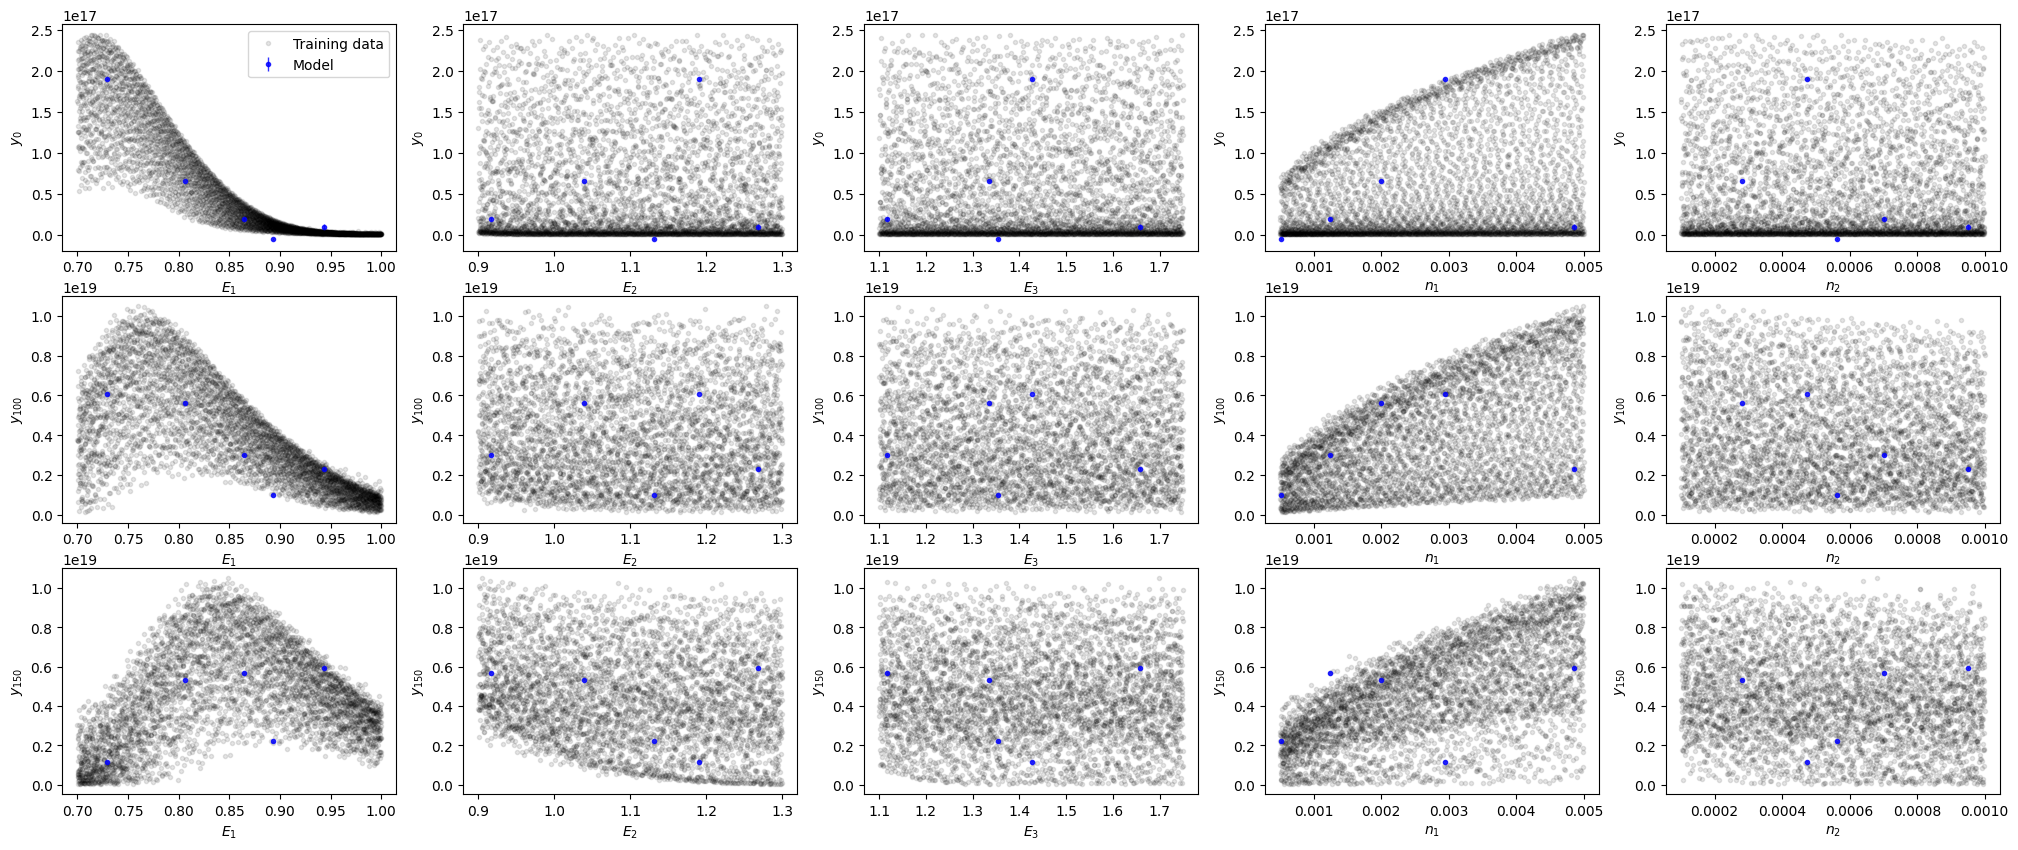

In [12]:
# Parameters for plot
color = "blue"
alpha = 0.8
xs = {"E1": r"$E_{1}$", "E2": r"$E_{2}$", "E3": r"$E_{3}$", "n1": r"$n_{1}$", "n2": r"$n_{2}$"}
ys = {f"y{i}": fr"$y_{{{i}}}$" for i in [0, 100, 150]}

# Plot some examples
nrow, ncol = len(ys), len(xs)
plt.subplots(nrow, ncol, figsize=(25, 10))
nplot = 0
for y, y_label in ys.items():
    for x, x_label in xs.items():
        nplot += 1
        plt.subplot(nrow, ncol, nplot)
        plt.errorbar(df_eval[x], df_mean[y], yerr=df_std[y], marker='.', lw=1, ls='None', color=color, alpha=alpha, label="Model")
        plt.plot(df_train[x], df_train[y], ".", color="black", alpha=0.1, label="Training data")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        if nplot==1: plt.legend()
plt.show()

We are now in a position to plot the output of the trained surrogate model together with the "truth" from the evaluation file. The intensity of the blue regions correspond to the probability as predicted by the surrogate. It can be seen that the truth mainly goes through the regions of high probability as predicted by the model. Thus we have trained an accurate surrogate for the tritium desorption process. This training was done on the cloud and the surrogate has been stored and can be evaluated extremely quickly, with uncertainty predictions built into the modelling.

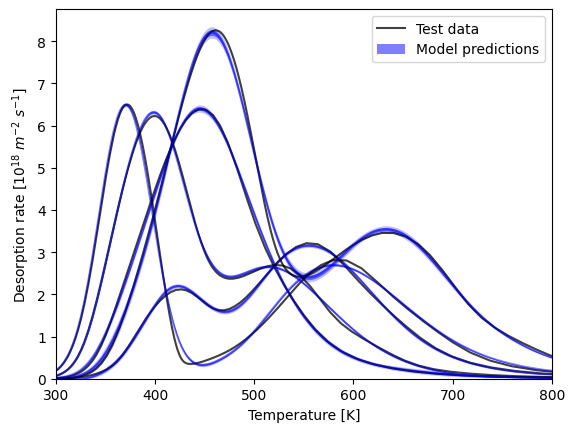

In [21]:
# Parameters for plot
error_inflation_factor = 1. # Factor to multiply error by for plotting
y_fac = 18 # Factor to divide y by for plotting [log10]
plot_eval = True
data_alpha = 0.75
plot_model_mean = True
plot_model_bands = True
plot_model_blur = False
nsigs = [1, 2]
model_alpha = 0.5
n_model_blur = 100
model_color = 'blue'
number_of_training_examples = 0
number_of_model_examples = 5

# Plot results
grid = df_grid.iloc[:, 0]
plt.subplots()
if (plot_model_blur or plot_model_bands) and not plot_model_mean: 
    plt.fill_between(grid, np.nan, np.nan, color=model_color, alpha=model_alpha, lw=0., label="Model predictions")
for example in range(number_of_training_examples): # Training examples
    train = df_train[y_outputs].iloc[example]/10**y_fac
    label = "Example training data" if example==0 else None
    plt.plot(grid, train, color='black', alpha=0.5, label=label)
for example in range(number_of_model_examples): # Model predictions
    mean = df_mean[y_outputs].iloc[example]/10**y_fac
    err = error_inflation_factor*df_std[y_outputs].iloc[example]/10**y_fac
    if plot_eval and (file_eval == campaign_dir + "test.csv"):
        eval = df_eval[y_outputs].iloc[example]/10**y_fac
        label = "Test data" if example==0 else None
        plt.plot(grid, eval, color='black', alpha=data_alpha, label=label)
    if plot_model_bands:
        for isig, nsig in enumerate(nsigs):
            label = "Model predictions" if (isig == 0) and (example == 0) else None
            plt.fill_between(grid, mean-nsig*err, mean+nsig*err, color=model_color, alpha=model_alpha/(isig+1), lw=0., label=label)
    if plot_model_blur and not plot_model_bands:
        alpha = tl.get_blur_alpha(n_model_blur, model_alpha)
        dys = tl.get_blur_boundaries(n_model_blur)
        for iy, dy in enumerate(dys):
            label = "Model predictions" if (iy == 0) and (example == 0) else None
            plt.fill_between(grid, mean-dy*err, mean+dy*err, color=model_color, alpha=alpha, lw=0., label=label)
    if plot_model_mean:
        label = "Model predictions" if (example==0) and (not plot_model_bands) and (not plot_model_blur) else None
        plt.plot(grid, mean, color=model_color, label=label, alpha=model_alpha)
plt.xlabel(r'Temperature [K]')
plt.xlim((grid.min(), grid.max()))
plt.ylabel(rf"Desorption rate [$10^{{{y_fac}}}$ $m^{{{-2}}}$ $s^{{{-1}}}$]")
plt.ylim(bottom=0.)
plt.legend()
plt.show()

Finally, delete the campaign if necessary...

In [14]:
tl.delete_campaign(campaign, verbose=True)

Response: ukaea campaign deleted successfully



... and delete the dataset if necessary.

In [15]:
tl.delete_dataset(file_train, verbose=True)

Response: ukaea.csv dataset and summary deleted successfully

